# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [8]:
!pip install matplotlib
import matplotlib

In [9]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [10]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [11]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [12]:
images[0]

'saint_bernard_53.jpg'

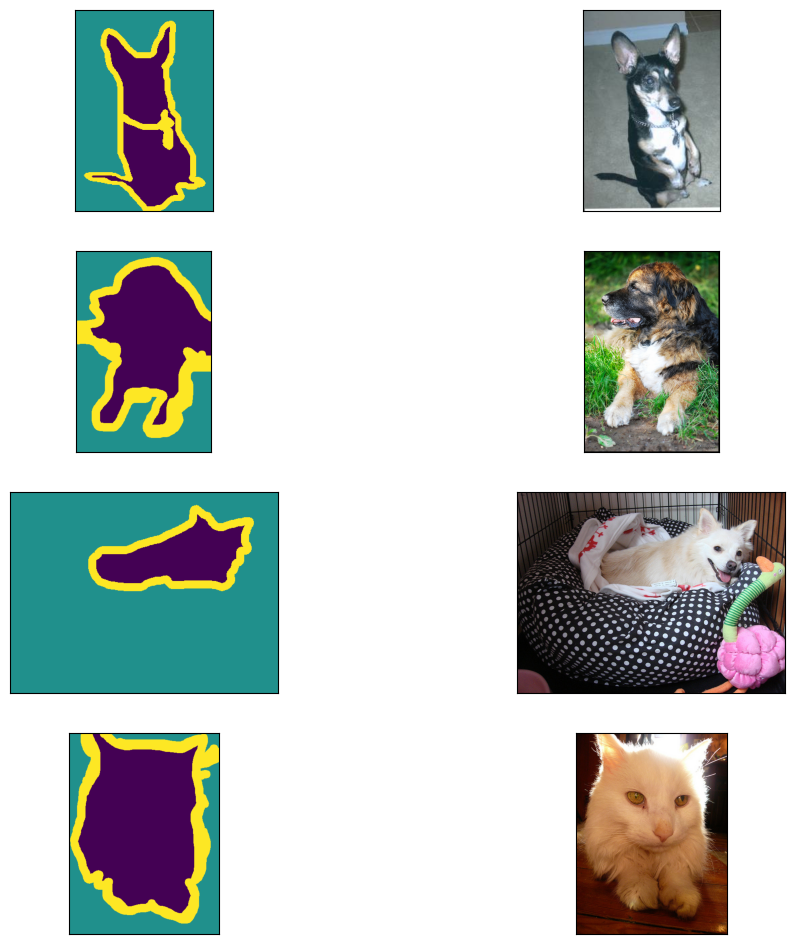

In [13]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [14]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [16]:
print(sagemaker.__version__)

2.240.0


In [17]:
role = sagemaker.get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 
                               'semantic-segmentation',
                              repo_version='latest')
print(training_image)

[03/09/25 03:06:11] INFO     Found credentials from IAM Role:                                   ]8;id=760919;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=488757;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=57629;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=529201;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=965254;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=866819;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/09/25 03:06:12] INFO     Ignoring unnecessary instance type: None.                            ]8;id=764496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=225953;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [18]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [19]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:05<00:00, 1430.21it/s]


In [20]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [21]:
print(len(train_annots), len(train_images))

5575 5577


# Uploading Data to S3

In [23]:
bucket_name = 'semanticsegmentationpetsdata'
sess = sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, key_prefix='train_annotation')
print('Training annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, key_prefix='validation_annotation')
print('Validation annotations uploaded')

[03/09/25 03:30:29] INFO     Found credentials from IAM Role:                                   ]8;id=309045;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=791258;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Starting upload
Training images uploaded
Training annotations uploaded
Validation images uploaded
Validation annotations uploaded


In [24]:
s3_validation_annotation_path

's3://semanticsegmentationpetsdata/validation_annotation'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# SageMaker Estimator

In [25]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://semanticsegmentationpetsdata/output',
    sagemaker_session=sess
)

[03/09/25 03:45:03] WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=704639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=241504;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=63562;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=418670;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_max_run has been renamed in sagemaker>=2.                     ]8;id=821237;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=107942;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_volume_size has been renamed in sagemaker>=2.                 ]8;id=161897;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=334077;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Found credentials from IAM Role:                                   ]8;id=737095;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=517854;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

# Hyperparameters

In [26]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)


# Data Channels

In [30]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                        content_type='image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                             content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                                                   content_type='image/png', s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                                                        content_type='image/png', s3_data_type='S3Prefix')


In [31]:
data_channel = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
}

In [32]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f6dea263460>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f6dea262620>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f6dea2628f0>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f6dea262b60>}

# Model Training

In [33]:
model.fit(inputs=data_channel, logs=True)

[03/09/25 04:09:30] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=773486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=630485;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=183211;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=807590;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-03-09-04-09-30-773                                         

2025-03-09 04:09:31 Starting - Starting the training job...
..25-03-09 04:09:45 Starting - Preparing the instances for training.
..............10:23 Downloading - Downloading input data.
........09 04:12:49 Downloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Mar  9 04:14:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                   

# Deploy Model

In [34]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

[03/09/25 04:40:58] INFO     Creating model with name:                                              ]8;id=769788;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=305938;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             semantic-segmentation-2025-03-09-04-40-58-209                                         

                    INFO     Creating endpoint-config with name                                     ]8;id=12150;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=107717;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             semantic-segmentation-2025-03-09-04-40-58-209                                         

                    INFO     Creating endpoint with name                                            ]8;id=175259;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=254556;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\
                             semantic-segmentation-2025-03-09-04-40-58-209                                         

-------------!
Model deployed!


# Predictions

In [35]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1815


In [36]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [49]:
index = 0

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [50]:
mask = np.array(Image.open(io.BytesIO(results)))

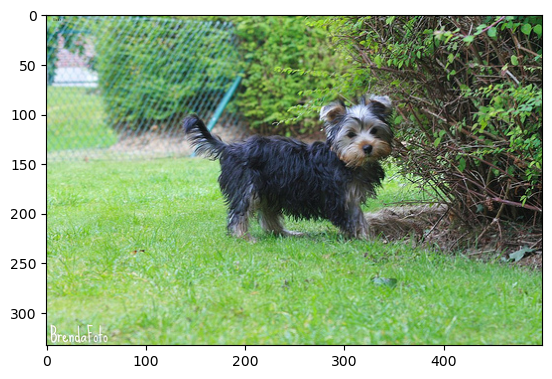

In [51]:
plt.imshow(plt.imread(image_path));

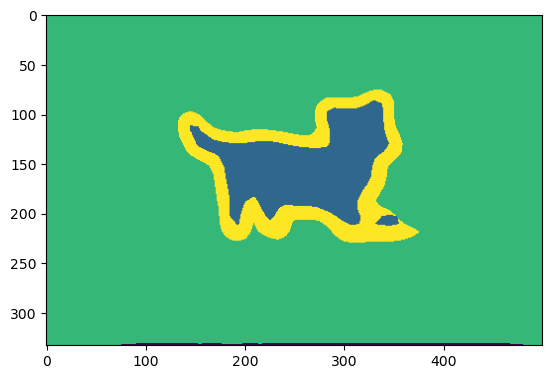

In [52]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [53]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

[03/09/25 04:52:35] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=689309;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=415320;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=307454;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=933140;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\
                             semantic-segmentation-2025-03-09-04-40-58-209                                         